## YOLO 11 Nano (Hyperparameter)

In [ ]:
# Install required libraries (minimal) 
!pip install -q ultralytics gdown

## 1-1. Environment Setup and Library Import

In [1]:
import os, glob, zipfile, random, math, gdown
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# If data ZIP is needed, specify file ID below (skip if already exists)
file_id = '1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz'  # Existing fire_smoke_detection.zip example
zip_path = 'fire_smoke_detection.zip'

if not os.path.exists('fire_smoke_detection/data.yaml') and not os.path.exists(zip_path):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', zip_path, quiet=False)

if os.path.exists(zip_path) and not os.path.exists('fire_smoke_detection/data.yaml'):
    with zipfile.ZipFile(zip_path, 'r') as zf: zf.extractall('.')

print("Dataset downloaded and extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz
From (redirected): https://drive.google.com/uc?id=1_HyLS8OP9oZtZOAi-rd-krUuAFs_Ytjz&confirm=t&uuid=8361d1c8-8540-422a-9e79-09a27b79c879
To: /fire_smoke_detection.zip
100%|██████████| 3.07G/3.07G [01:06<00:00, 46.0MB/s]


Dataset downloaded and extracted.


In [3]:
# Check GPU
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

CUDA Available: True
GPU: NVIDIA GeForce RTX 5090
CUDA Version: 12.8


## 1-2. Visualization Function

In [4]:
def visualize_grid(model, image_dir: str, label_dir: str, rows: int = 3, cols: int = 3):
    if not os.path.exists(image_dir):
        raise RuntimeError(f'Image directory not found: {image_dir}')
    if not os.path.exists(label_dir):
        raise RuntimeError(f'Label directory not found: {label_dir}')

    img_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    label_backed = []
    for f in img_files:
        stem = os.path.splitext(f)[0]
        if os.path.exists(os.path.join(label_dir, stem + '.txt')):
            label_backed.append(f)

    if len(label_backed) == 0:
        raise RuntimeError('No images with label files found.')

    sample_count = min(rows * cols, len(label_backed))
    sample_imgs = random.sample(label_backed, sample_count)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for idx, f in enumerate(sample_imgs):
        img_path = os.path.join(image_dir, f)
        infer_results = model(img_path, verbose=False)
        r = infer_results[0]
        plotted = r.plot()
        axes[idx].imshow(plotted)
        axes[idx].axis('off')
        axes[idx].set_title(f, fontsize=8)

    for k in range(sample_count, rows * cols):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

## 2. Data Configuration

In [5]:
# Check dataset path
data_yaml = r'fire_smoke_detection/data.yaml'

# Check file existence
if os.path.exists(data_yaml):
    print(f"Data config file found: {data_yaml}")
    
    # Check data.yaml content
    with open(data_yaml, 'r') as f:
        print("\ndata.yaml content:")
        print(f.read())
else:
    print(f"Data config file not found: {data_yaml}")

Data config file found: fire_smoke_detection/data.yaml

data.yaml content:
# 로컬 환경용 경로 설정 (YAML 파일 기준 상대 경로)
train: data/train/images
val: data/val/images  
test: data/test/images

# Classes
names: ['smoke', 'fire']  # Replace with your actual class names

# Counts
nc: 2  # number of classes
train_count: 14122
val_count: 3099
test_count: 4306



In [7]:
# Set hyp.yaml path
hyp_path = r'fire_smoke_detection/hyp.yaml'

# Check file existence
if os.path.exists(hyp_path):
    print(f"Hyperparameter config file found: {hyp_path}")
    
    # Check hyp.yaml content
    with open(hyp_path, 'r') as f:
        print("\nhyp.yaml content:")
        print(f.read())
else:
    print(f"Hyperparameter config file not found: {hyp_path}")

Hyperparameter config file found: fire_smoke_detection/hyp.yaml

hyp.yaml content:

# RT-DETR Fire-Smoke Detection 최적 하이퍼파라미터
# YOLOv11n 학습 결과 분석 기반 (mAP50: 0.7615 → 0.80+ 목표)

# ========== 학습률 설정 ==========
lr0: 0.002              # 초기 학습률 (안정적 수렴)
lrf: 0.01               # 최종 학습률 비율
momentum: 0.937         # SGD momentum
weight_decay: 0.0005    # L2 정규화 (과적합 방지)
warmup_epochs: 5.0      # Warm-up 기간
warmup_momentum: 0.8
warmup_bias_lr: 0.1

# ========== Data Augmentation ==========
# Mosaic & Mix
mosaic: 1.0             # Mosaic augmentation (0.0-1.0)
mixup: 0.15             # MixUp augmentation (클래스 경계 학습)
copy_paste: 0.3         # Copy-Paste (작은 화재/연기 객체 증강)

# 기하학적 변환
degrees: 10.0           # 회전 각도 (-deg ~ +deg) - 카메라 각도 변화
translate: 0.2          # 이동 (0.0-1.0) - 객체 위치 다양화
scale: 0.7              # 크기 변화 (gain) - 화재 크기 다양성
shear: 0.0              # 전단 변환 (화재에는 불필요)
perspective: 0.0        # 원근 변환 (화재에는 불필요)
flipud: 0.0             # 상하 반전 (화재는 아래, 연기는 위 - 비활성화)
fliplr: 0.5       

## 3. Load YOLOv11n Model

In [8]:
# Load lightweight model
model = YOLO('yolo11n.pt')

## 4. Hyperparameter Training

In [9]:
hyp_batch = 32
num_workers = 8           # Linux dataloader workers
project_name = 'yolo11n_fire_smoke'

results_hyp = model.train(
    data=data_yaml,
    cfg=hyp_path,
    epochs=50,
    imgsz=640,
    batch=hyp_batch,
    device=0,
    workers=8,
    cache=False,
    amp=True,
    patience=10,
    project=project_name,
    name='yolo11n_hyp',
    exist_ok=True,
    verbose=True,
)

print('Hyperparameter training complete.')

Ultralytics 8.3.233 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32120MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=fire_smoke_detection/hyp.yaml, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fire_smoke_detection/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_hyp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

## 5. Validation Evaluation

In [10]:
val_metrics_hyp = model.val(data=data_yaml,
                            batch=hyp_batch,
                            device=0,
                            project=project_name,
                            name='yolo11n_val_hyp',
                            verbose=True)
print('[Hyperparameter Validation Metrics]')
print(val_metrics_hyp)

Ultralytics 8.3.233 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32120MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3791.1±2568.3 MB/s, size: 129.4 KB)
val: Scanning /fire_smoke_detection/data/val/labels.cache... 3099 images, 1375 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3099/3099 11.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 97/97 23.3it/s 4.2s0.1s
                   all       3099       3932      0.777      0.669      0.758      0.436
                 smoke       1550       1756      0.825       0.74      0.822      0.501
                  fire        879       2176      0.729      0.598      0.695      0.371
Speed: 0.2ms preprocess, 0.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /yolo11n_fire_smoke/yolo11n_val_hyp
[Hyperparameter Validation Metrics]
ultralytics.utils

### 5-1. Validation Image Detection Visualization

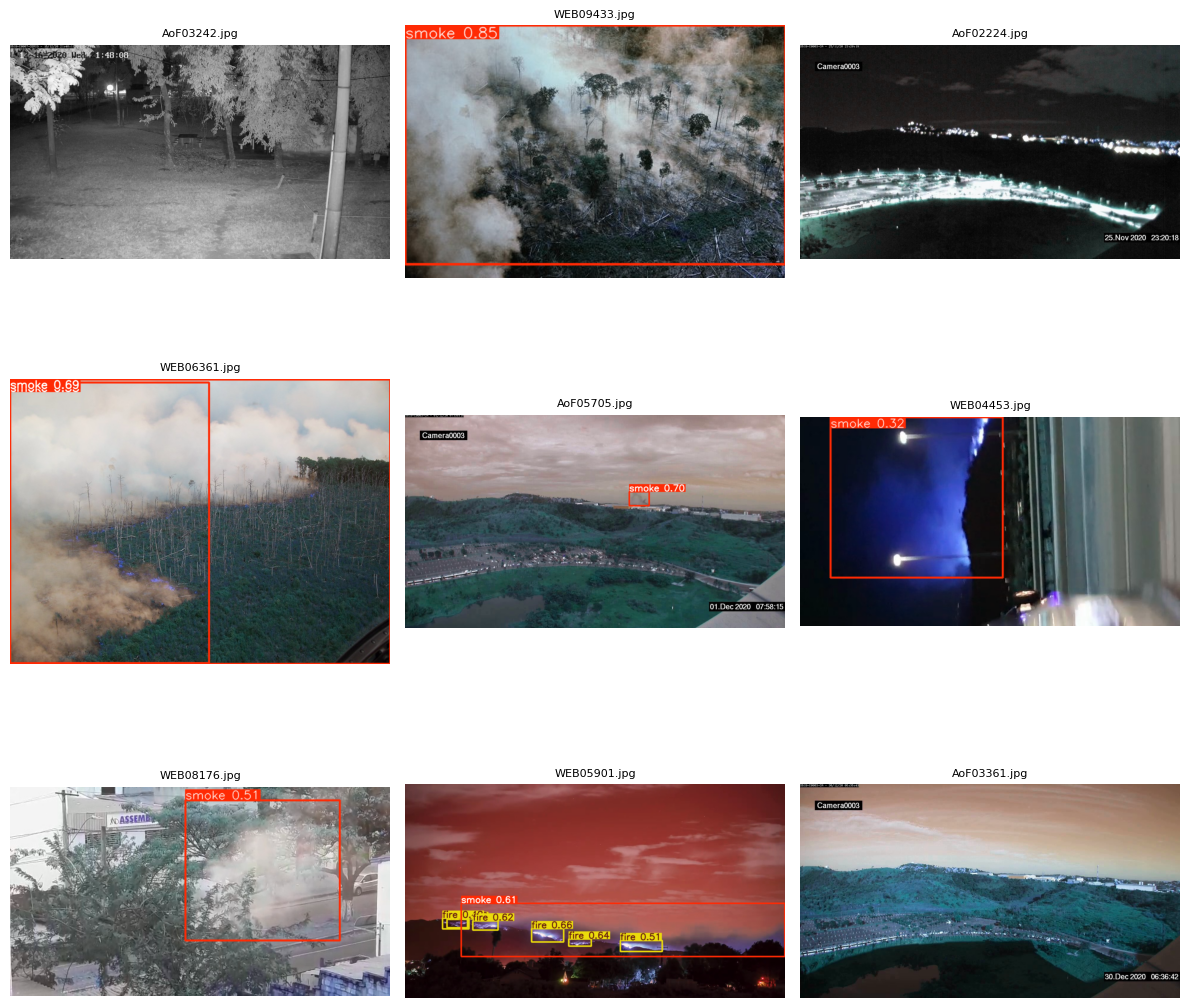

In [11]:
val_img_dir = 'fire_smoke_detection/data/val/images'
val_lbl_dir = 'fire_smoke_detection/data/val/labels'
visualize_grid(model, val_img_dir, val_lbl_dir, rows=3, cols=3)

## 6. Test Set Evaluation

In [12]:
test_metrics_hyp = model.val(data=data_yaml, 
                             split='test', 
                             batch=hyp_batch, 
                             device=0,
                             project=project_name,
                             name='yolo11n_test_hyp',
                             verbose=True)
print('[Hyperparameter Test Metrics]')
print(test_metrics_hyp)

Ultralytics 8.3.233 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5090, 32120MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5622.5±2190.3 MB/s, size: 209.6 KB)
val: Scanning /fire_smoke_detection/data/test/labels... 4306 images, 2005 backgrounds, 4 corrupt: 100% ━━━━━━━━━━━━ 4306/4306 1.3Kit/s 3.4s0.0ss
val: /fire_smoke_detection/data/test/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: /fire_smoke_detection/data/test/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: /fire_smoke_detection/data/test/images/WEB11243.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11244.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11245.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detection/data/test/images/WEB11313.jpg: corrupt JPEG restored and saved
val: /fire_smoke_detecti

### 6-1. Test Image Detection Visualization

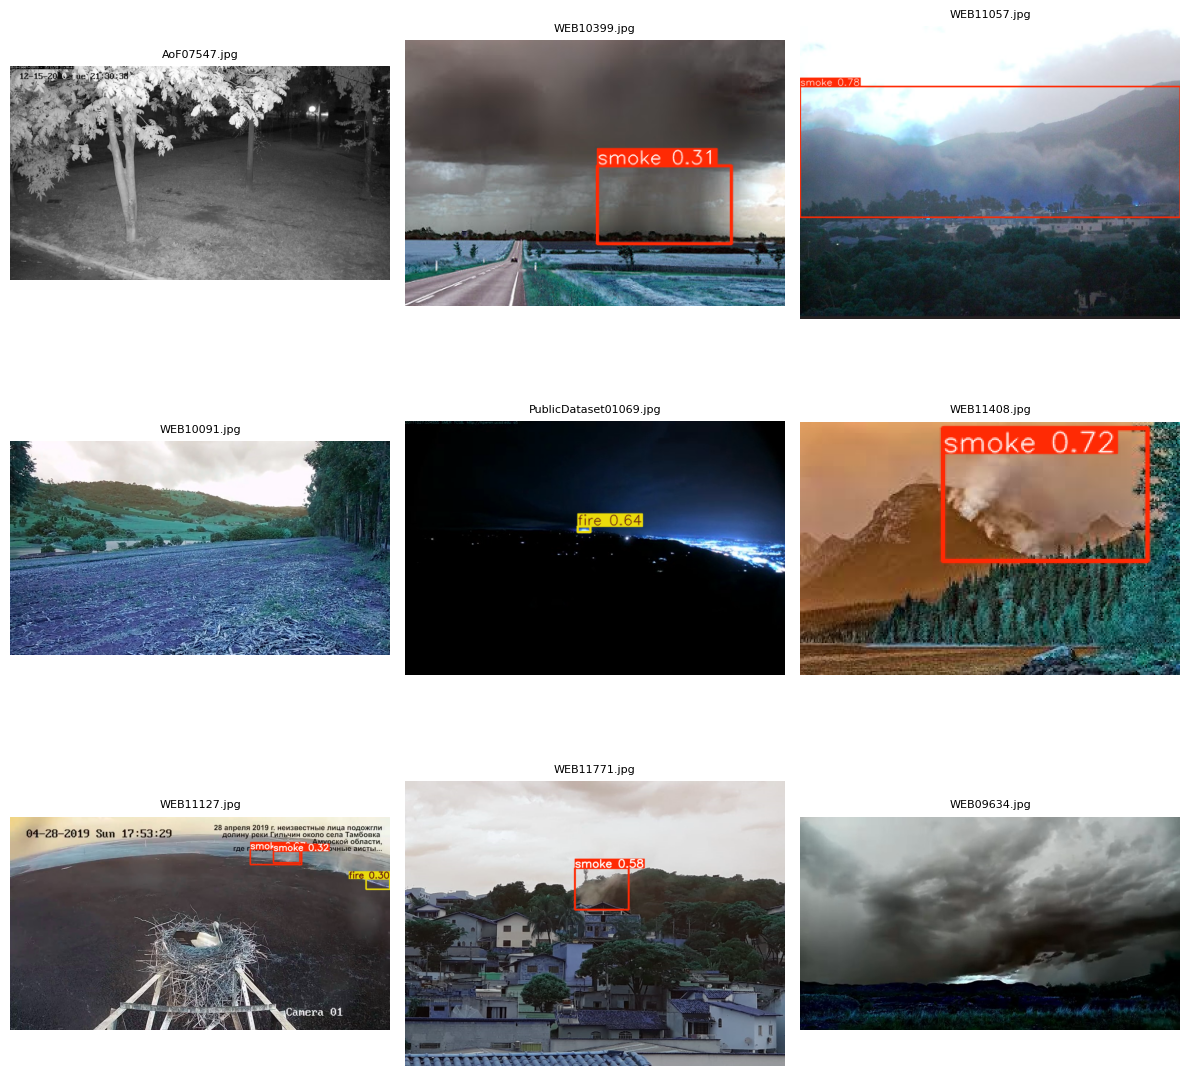

In [13]:
test_img_dir = 'fire_smoke_detection/data/test/images'
test_lbl_dir = 'fire_smoke_detection/data/test/labels'
visualize_grid(model, test_img_dir, test_lbl_dir, rows=3, cols=3)